In [ ]:
!pip install yfinance
!pip install pandas_market_calendars
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 6.7 MB/s eta 0:00:00
E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
!pip install ucimlrepo  # instalar un paquete específico llamado ucimlrepo

In [ ]:
#función diseñada para facilitar la descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

#Traigo el  dataset
air_quality = fetch_ucirepo(id=360)

#data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# variable information
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
from google.colab import drive
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que vamos a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Mostrar el DataFrame resultante
print(df.head())

        Date      Time  C6H6(GT)     T    RH
0  3/10/2004  18:00:00      11.9  13.6  48.9
1  3/10/2004  19:00:00       9.4  13.3  47.7
2  3/10/2004  20:00:00       9.0  11.9  54.0
3  3/10/2004  21:00:00       9.2  11.0  60.0
4  3/10/2004  22:00:00       6.5  11.2  59.6


In [ ]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' pusimos dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrar las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6(GT), T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6(GT), T, RH, Datetime]
Index: []


In [ ]:
# Establecer la columna datetime como índice
df.set_index('Datetime', inplace=True)

# Eliminar las columnas Date y Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Cambiar el nombre de la avriable C6H6(GT)
df.rename(columns={'C6H6(GT)': 'C6H6'}, inplace=True)

num_filas = len(df)
print(num_filas)

9357


In [ ]:
# Graficamos las series temporales
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

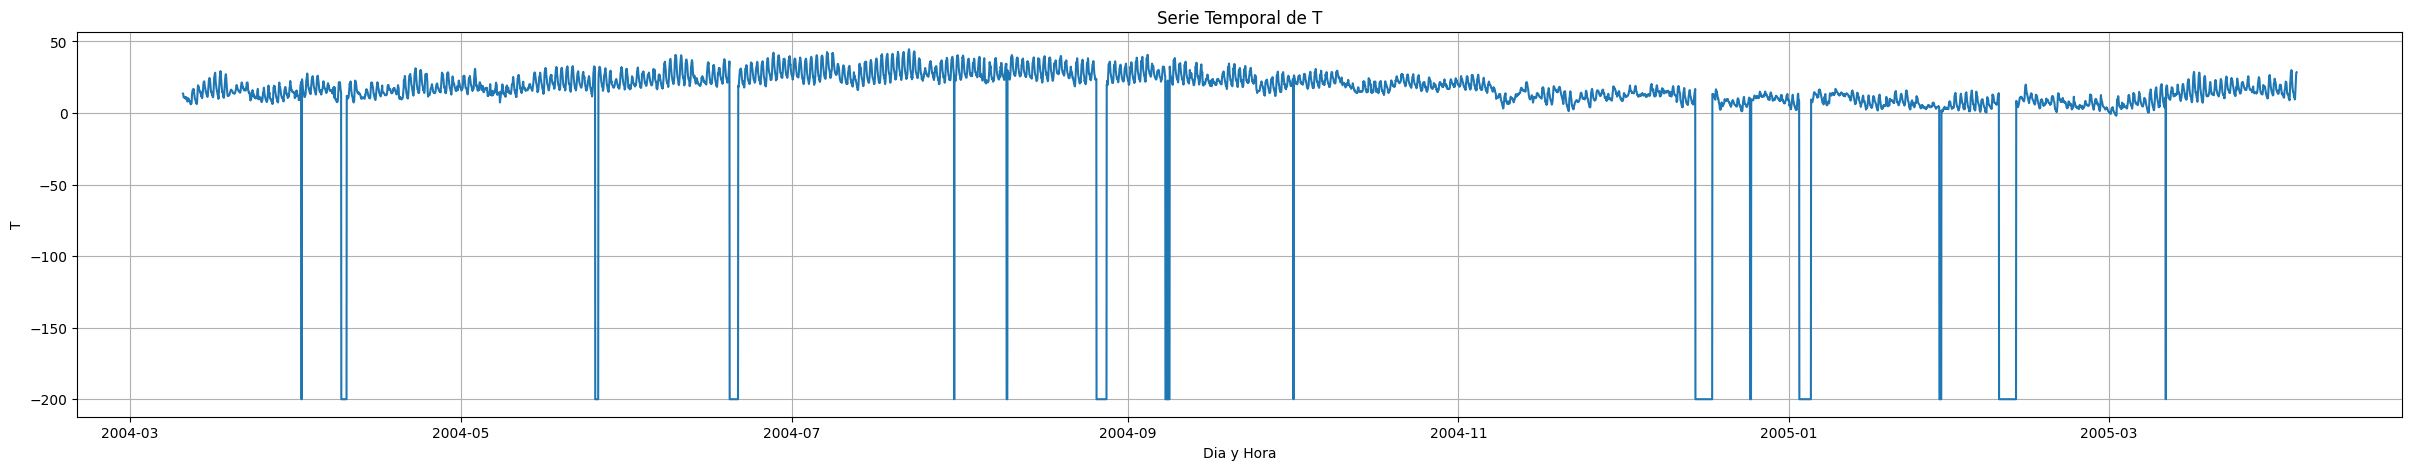

In [ ]:
# Graficar la serie temporal de T
plt.figure(figsize=(30, 5))
plt.plot(df.index, df['T'], linestyle='-')
plt.title('Serie Temporal de T')
plt.xlabel('Dia y Hora')
plt.ylabel('T')
plt.grid(True)
plt.show()

MODIFICACION EN LOS DATOS, ELIMINANDO LOS VALORES -200, CON EL METODO FORWARD FILL

In [ ]:
 # Variable Temperatura T
# Reemplazar los valores -200 en la columna T con NaN
df['T'] = df['T'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['T'].fillna(method='ffill', inplace=True)

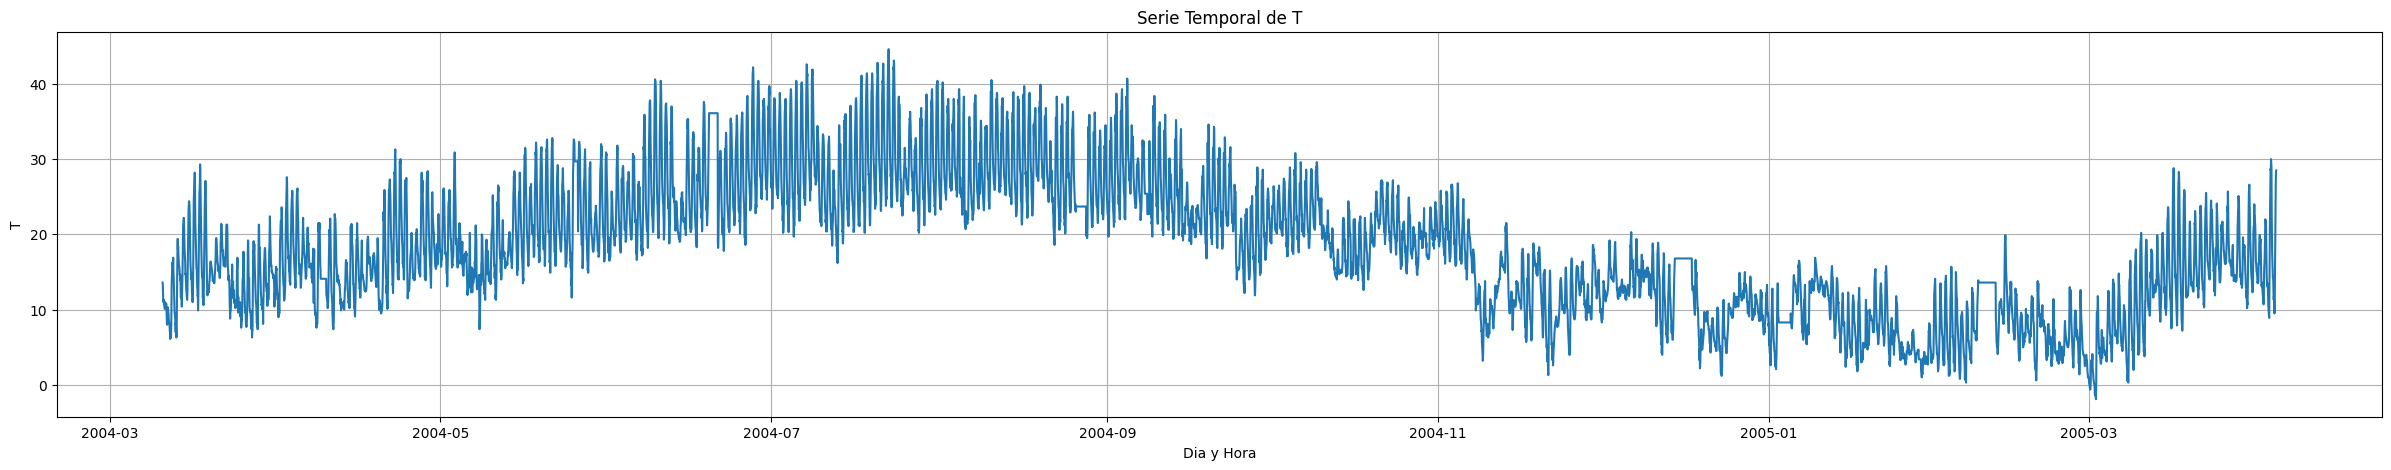

In [ ]:
# Graficar la serie temporal de T
plt.figure(figsize=(30, 5))
plt.plot(df.index, df['T'], linestyle='-')
plt.title('Serie Temporal de T')
plt.xlabel('Dia y Hora')
plt.ylabel('T')
plt.grid(True)
plt.show()

EN ESTA GRAFICA, SE VE CLARAMENTE ESTACIONARIEDAD DE LA SERIE (CADA 24 HORAS), Y LA TENDENCIA QUE CORRESPONDE A LAS ESTACIONES DEL AÑO., LA CUAL SE TIENE QUE SACAR.

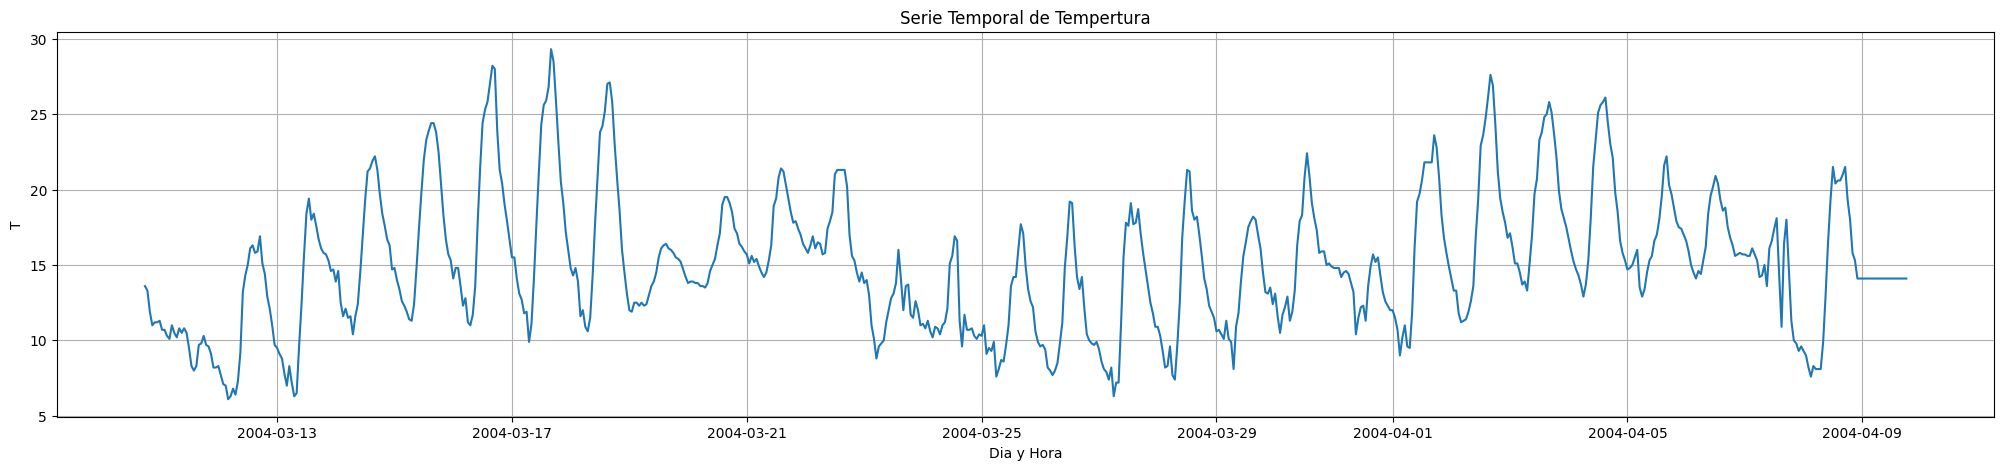

In [ ]:
# Filtrar para un solo mes de la serie T
start_datetime = '2004-03-10 18:00:00'
end_datetime = '2004-04-09 18:00:00'
df_filtrado_T = df.loc[start_datetime:end_datetime]

#Graficar la serie temporal de T° del 1° mes
plt.figure(figsize=(25, 5))
plt.plot(df_filtrado_T.index, df_filtrado_T['T'], linestyle='-')
plt.title('Serie Temporal de Tempertura')
plt.xlabel('Dia y Hora')
plt.ylabel('T')
plt.grid(True)
plt.show()

DESCOMPOSICION DE LA SERIE VARIABLE T

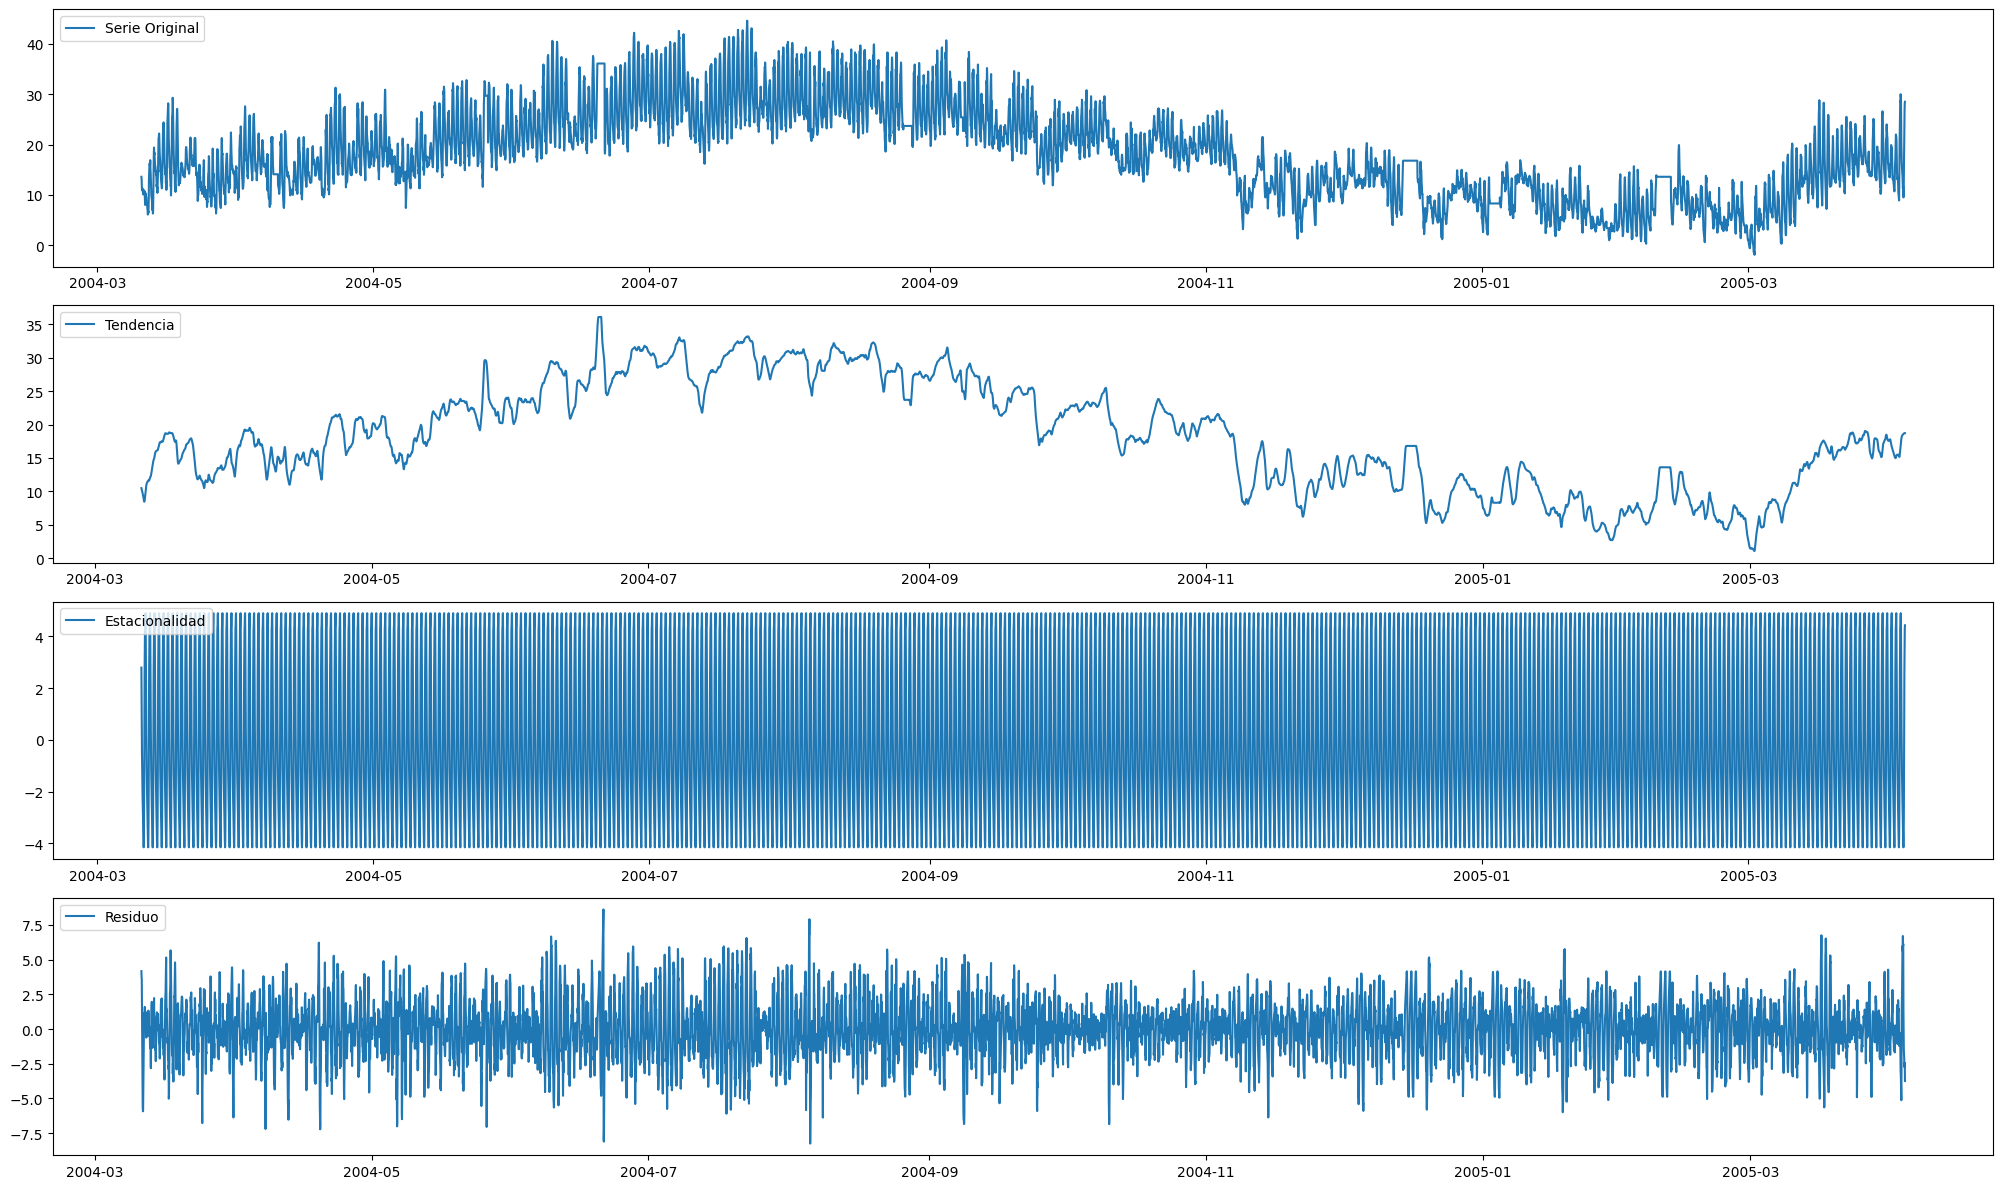

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
result_T = seasonal_decompose(df['T'], model='additive')

# Configurar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))

# Serie original
plt.subplot(411)
plt.plot(df['T'], label='Serie Original')
plt.legend(loc='upper left')

# Componente de tendencia
plt.subplot(412)
plt.plot(result_T.trend, label='Tendencia')
plt.legend(loc='upper left')

# Componente estacional
plt.subplot(413)
plt.plot(result_T.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

# Componente residual
plt.subplot(414)
plt.plot(result_T.resid, label='Residuo')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Para el correcto analisis de la serie temporal, tenemos que eliminar la tendencia de la misma; que se observa claramente como la curva sube en los meses de más calor, y disminuye en los mese de invierno.

# **PUNTO 3**

Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?

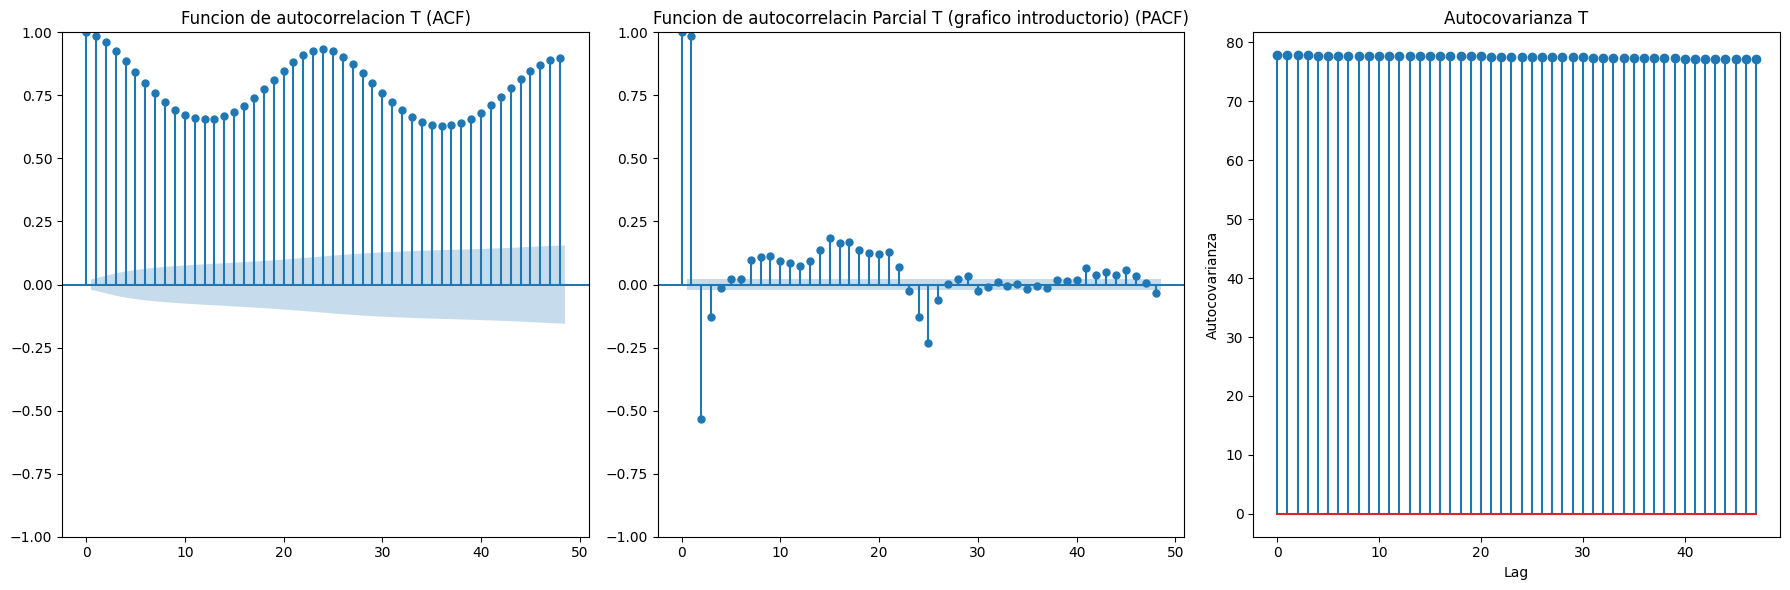

In [ ]:
# Grafica de ACF, PACF y autocovarianza para T
import statsmodels.api as sm
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
Y=df['T']
sm.graphics.tsa.plot_acf(Y, lags=48, ax=ax[0])
ax[0].set_title('Funcion de autocorrelacion T (ACF)')

sm.graphics.tsa.plot_pacf(Y, lags=48, ax=ax[1])
ax[1].set_title('Funcion de autocorrelacin Parcial T (grafico introductorio) (PACF)')

def autocovariance(series, lag):
    series_mean = np.mean(series)
    n = len(series)
    return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

lags = np.arange(48)
autocov = [autocovariance(Y, lag) for lag in lags]

ax[2].stem(lags, autocov, use_line_collection=True)
ax[2].set_title('Autocovarianza T')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('Autocovarianza')

plt.tight_layout()
plt.show()

# **PUNTO 4**
*Realizar distintas pruebas de raices unitarias para determinar si las series son o no estacionarias*

Aplicamos distintos test, para ver si la serie con la que se esta trabajando tienen o no estacionariedad, y poder determinar si es necesario diferenciarla para su correcto análisis.

**Test ADF (Dickey-Fuller Aumentado)**

El Test ADF evalúa la hipótesis nula de que una serie temporal tiene una raíz unitaria (es no estacionaria). Un p-valor menor que un nivel de significancia dado (como 0.05) sugiere que se puede rechazar la hipótesis nula y considerar la serie como estacionaria.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log

In [ ]:
# Realizamos el test de Dickey-Fuller
ADF_T = adfuller(df['T'])
print('ADF Statistic: %f' % ADF_T[0])#imprime sólo el estadístico
print('p-value: %f' % ADF_T[1]) #imprime sólo el p-valor

ADF Statistic: -3.207005
p-value: 0.019583


El p-valor es menor a 0.05, por lo que se puede rechazar la H0 y establecer la estacionariedad de la serie.

**Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

El Test KPSS se utiliza una hipótesis nula contraria al test anterior.

Hipótesis nula (H0): La serie es estacionaria, no presenta raiz unitaria.

In [ ]:
# Realizamos el Test KPSS
kpss_T= kpss(df['T'])
print('Kpss Statistic: %f' % kpss_T[0])  # imprime sólo el estadístico
print('p-value: %f' % kpss_T[1])  # imprime sólo el p-valor


Kpss Statistic: 7.457569
p-value: 0.010000


<ipython-input-17-3c791b2a6c43>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_T= kpss(df['T'])


Tambien se rechaza la H0 en este test. La serie es no estacionaria.

**Test Phillips-Perron:**

In [ ]:
!pip install arch
import arch
from arch.unitroot import PhillipsPerron

# Realizar el test de Phillips-Perron
pp_result = PhillipsPerron(df['T'])

# Mostrar los resultados
print('Estadístico PP:', pp_result.stat)
print('Valor p:', pp_result.pvalue)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.8 MB/s eta 0:00:00
Estadístico PP: -7.25923996722257
Valor p: 1.6986260472241785e-10


El p-valor da menor a 0.05, por lo tanto rechazo la H0. Se asume que la serie es estacionaria.

Otra manera de saber si es necesario que se aplique una diferenciación a nuestra serie temporal, es mediante la función ndiffs de la libreria pmdarima.

In [ ]:
!pip install pmdarima
import pmdarima as pm
print(pm.arima.ndiffs(df['T']))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
1


Aunque los test me rechazaron la H0, esta función me arroja que necesitaria realizar una diferenciacion, para eliminar la tendencia estacional de mis datos y lograr la estacionariedad de la misma.

Aplico dicha diferenciación a mis datos originales para la variable T

In [ ]:
# Diferenciación de T
df_T_dif = df['T'].diff(1).dropna()
print(len(df_T_dif))

9356


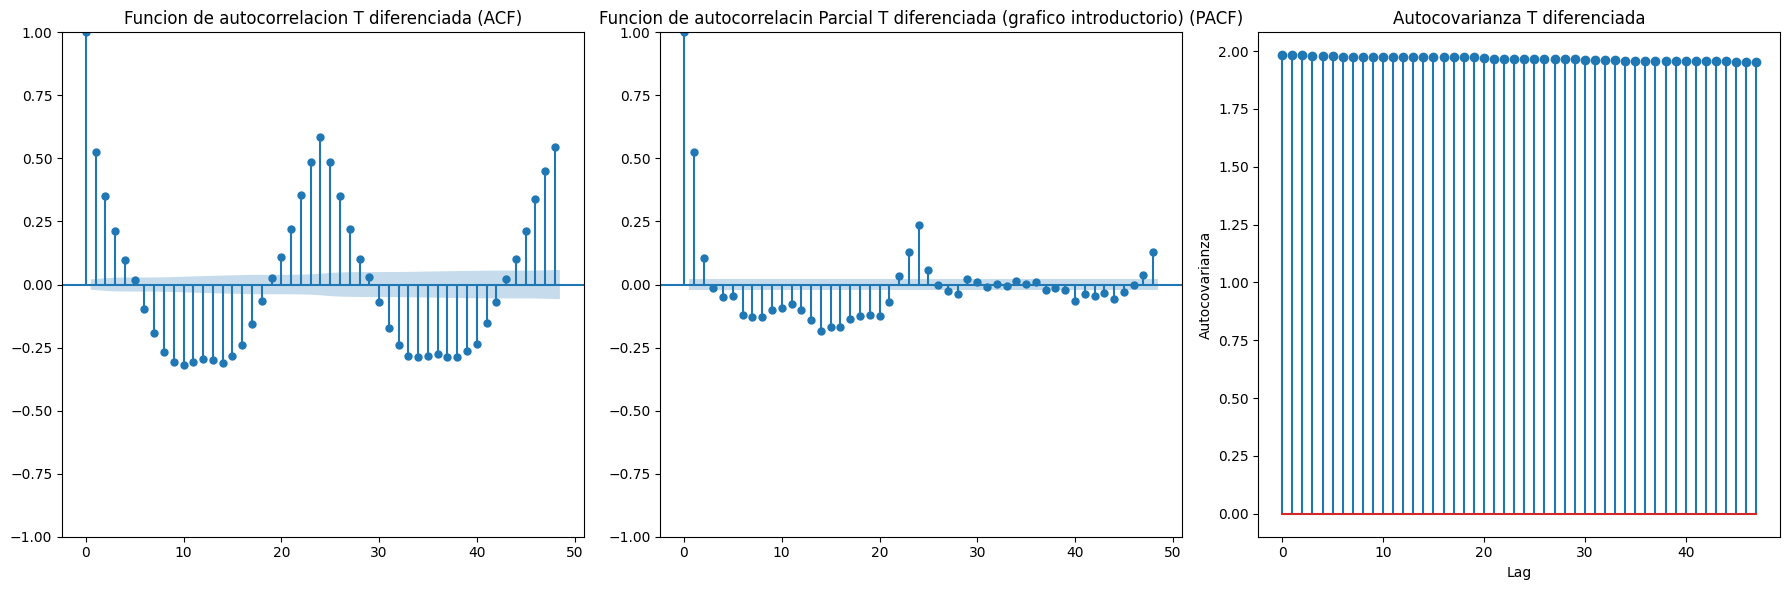

In [ ]:
# Grafica de ACF, PACF y autocovarianza para T
import statsmodels.api as sm
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
Y=df_T_dif
sm.graphics.tsa.plot_acf(Y, lags=48, ax=ax[0])
ax[0].set_title('Funcion de autocorrelacion T diferenciada (ACF)')

sm.graphics.tsa.plot_pacf(Y, lags=48, ax=ax[1])
ax[1].set_title('Funcion de autocorrelacin Parcial T diferenciada (grafico introductorio) (PACF)')

def autocovariance(series, lag):
    series_mean = np.mean(series)
    n = len(series)
    return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

lags = np.arange(48)
autocov = [autocovariance(Y, lag) for lag in lags]

ax[2].stem(lags, autocov, use_line_collection=True)
ax[2].set_title('Autocovarianza T diferenciada')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('Autocovarianza')

plt.tight_layout()
plt.show()

Con estas graficas saco los valores de p, q, miniuscula que corresponden a la parte no estacionaria de la serie.

p= 1 (por el corte abrupto después del primer lag en la PACF)

q= 2 y 3 (probar las 2 opciones, dado los primeros picos significativos en la ACF)

d=1 porque la diferencie una vez para lograr la estacionariedad.


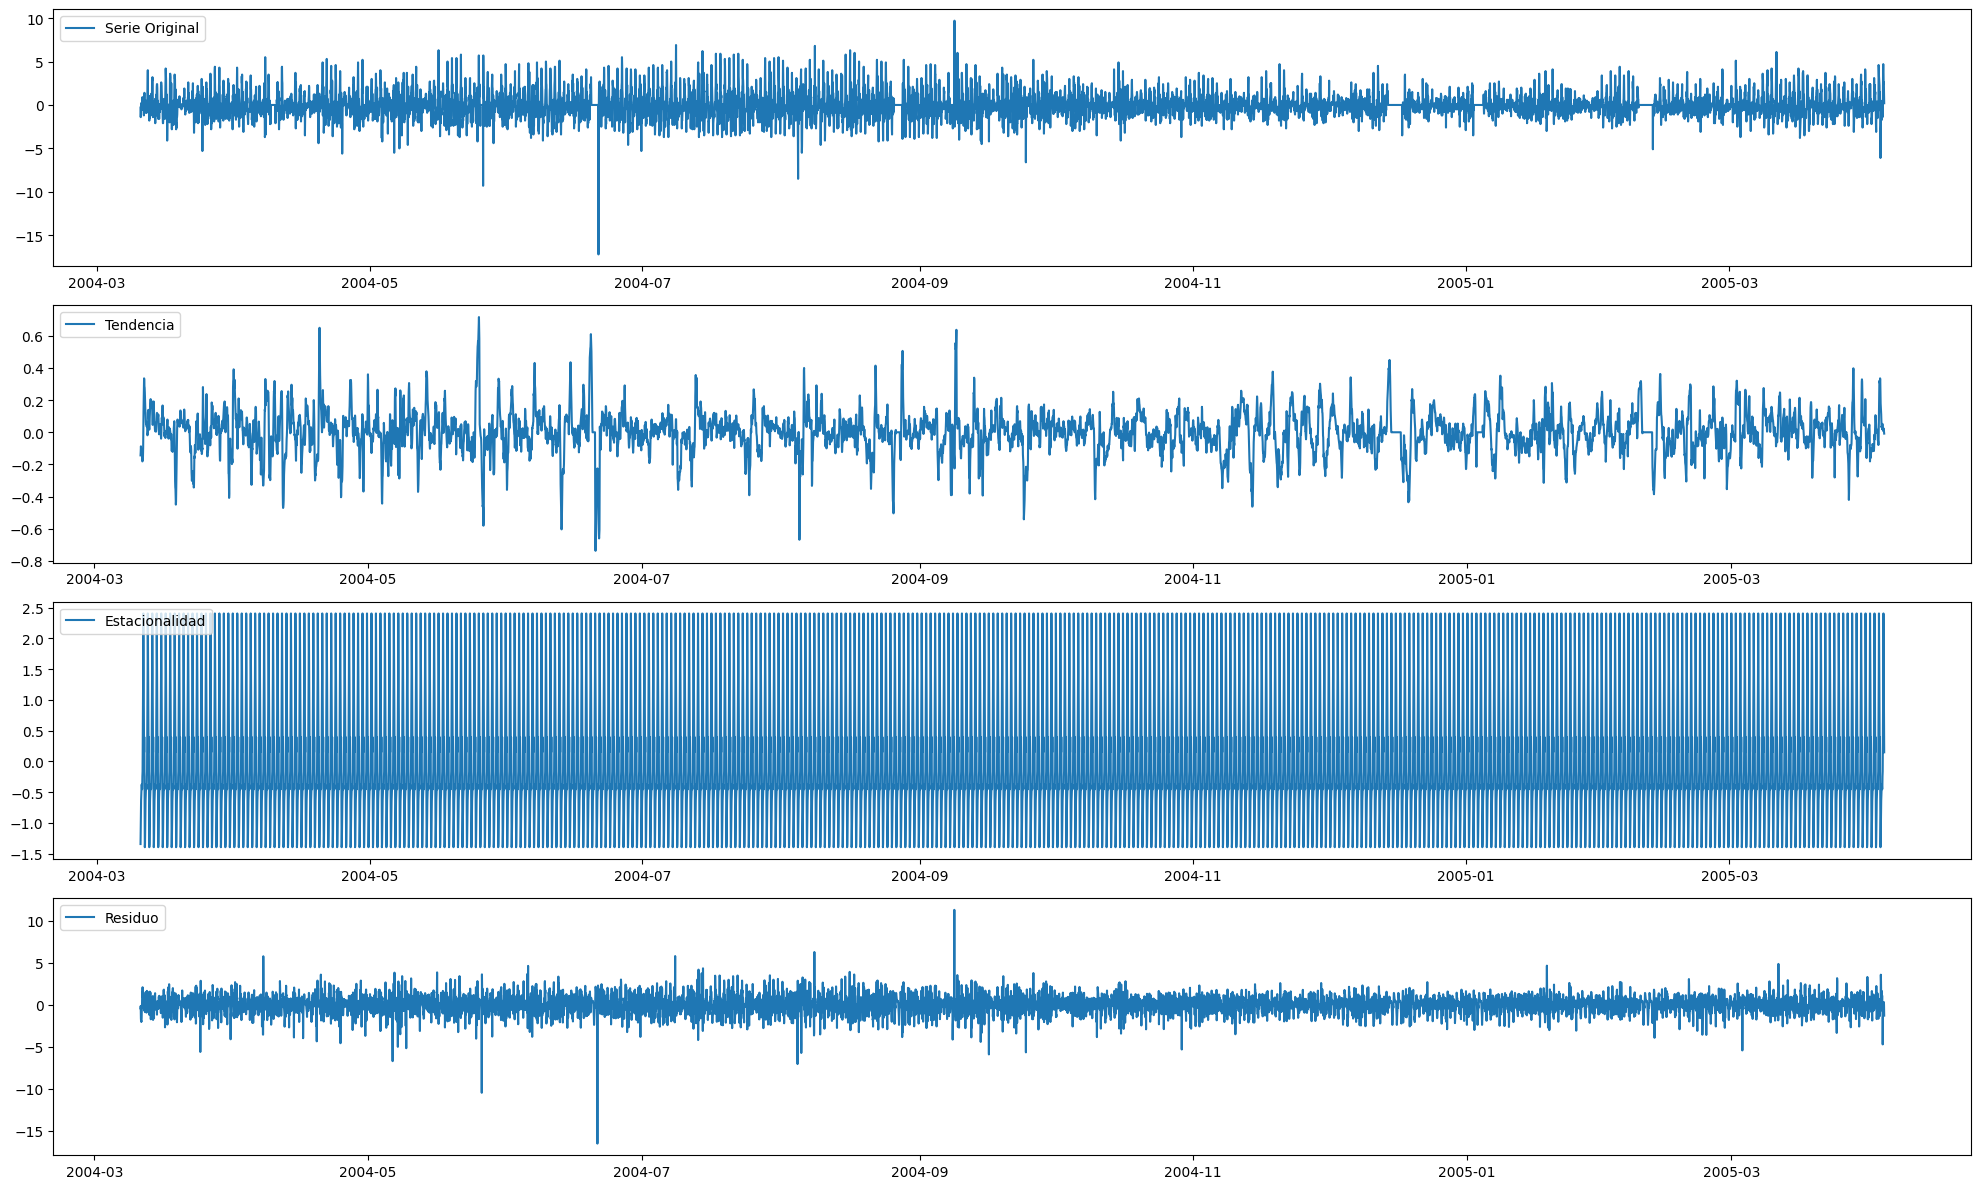

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
result_T = seasonal_decompose(df_T_dif, model='additive')

# Configurar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))

# Serie original
plt.subplot(411)
plt.plot(df_T_dif, label='Serie Original')
plt.legend(loc='upper left')

# Componente de tendencia
plt.subplot(412)
plt.plot(result_T.trend, label='Tendencia')
plt.legend(loc='upper left')

# Componente estacional
plt.subplot(413)
plt.plot(result_T.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

# Componente residual
plt.subplot(414)
plt.plot(result_T.resid, label='Residuo')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


En estas gráficas se observa claramente, como la tendencia que tenia se "aplana", eliminando la estacionalidad de mi serie temporal.


El segundo paso, es eliminar la estacionalidad que ocurre cada 24 horas, lo que genera picos en mi serie.

In [ ]:
# Diferenciación regular d=24 hora de T
df_T_24 = df_T_dif.diff(24).dropna()
print(len(df_T_24))

9332


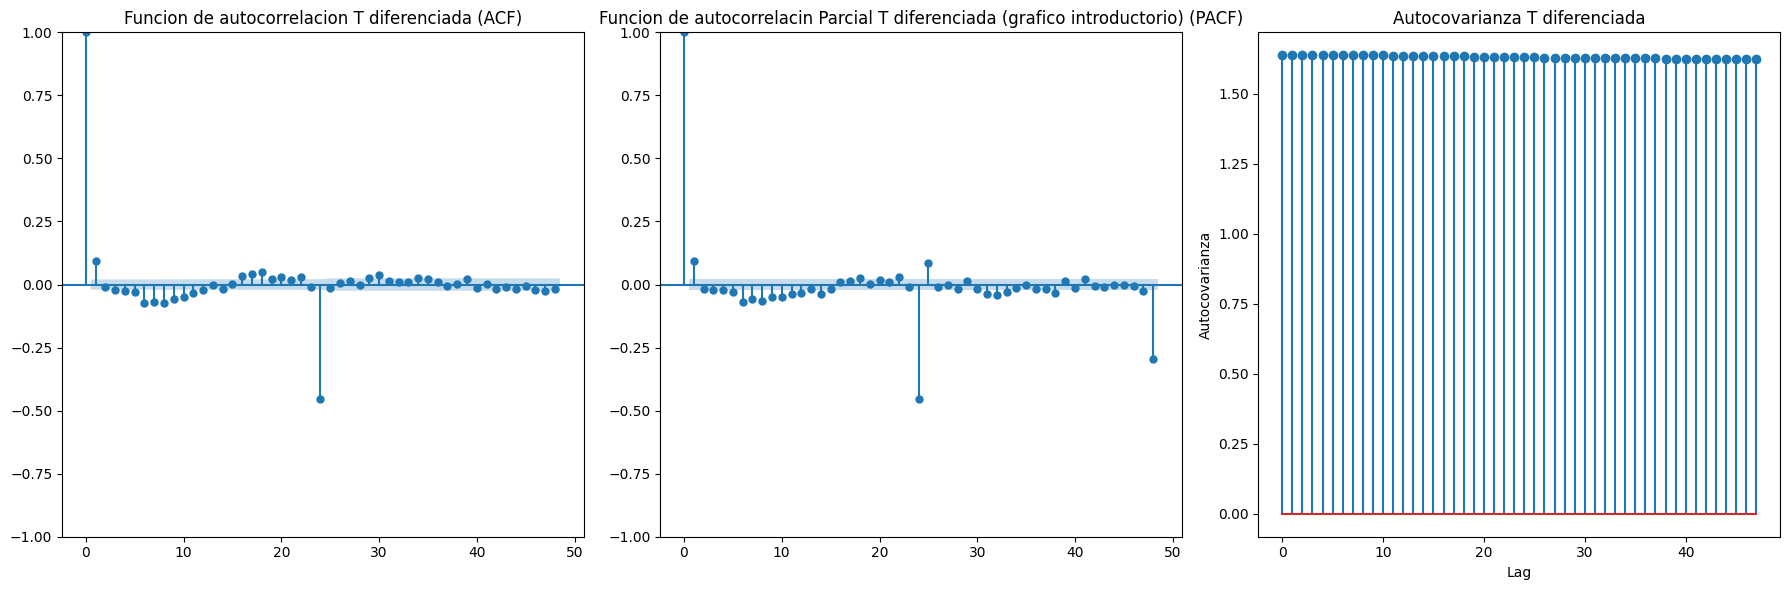

In [ ]:
# Grafica de ACF, PACF y autocovarianza para T
import statsmodels.api as sm
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
Y=df_T_24
sm.graphics.tsa.plot_acf(Y, lags=48, ax=ax[0])
ax[0].set_title('Funcion de autocorrelacion T diferenciada (ACF)')

sm.graphics.tsa.plot_pacf(Y, lags=48, ax=ax[1])
ax[1].set_title('Funcion de autocorrelacin Parcial T diferenciada (grafico introductorio) (PACF)')

def autocovariance(series, lag):
    series_mean = np.mean(series)
    n = len(series)
    return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

lags = np.arange(48)
autocov = [autocovariance(Y, lag) for lag in lags]

ax[2].stem(lags, autocov, use_line_collection=True)
ax[2].set_title('Autocovarianza T diferenciada')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('Autocovarianza')

plt.tight_layout()
plt.show()

Con el análisis de estas gráficas, podemos determinar los valores adecuados para usar en nuestro primer modelo SARIMA, para los parametros de la parte estacionaria del modelo (P y Q).

P= 2, 1 (probar dos opciones, 2 picos en la PACF)

Q= 1 (1 pico en la ACF)

Se determina D=1 ya que fue necesaria hacer una diferenciación.

Mientras que m=24 (ya que cada 24 horas se cumple un ciclo).


# **PUNTO 5**
*Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).*

Los modelos SARIMAX, se aplican al dataset con los datos originales, ya que dentro del algoritmo, establecemos que d=1 y D=1. Realiza las diferenciaciones tanto en la parte no estacionaria como en la estacionaria. Es por esto, que no es necesario aplicar los datos diferencias; en caso de hacerlo, deberiamos establecer los parametros d, D con valor de 0.

Probar distintos modelos:

Modelo 1 = (1,1,1)(1,1,1,24)

Modelo 2 = (1,1,2)(1,1,1,24)

Modelo 3 = (1,1,3)(1,1,1,24)

Modelo 4 = (1,1,1)(2,1,1,24)

Modelo 5 = (1,1,2)(2,1,1,24)

Modelo 6 = (1,1,3)(2,1,1,24)

In [ ]:
# MODELO 1 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_1 = SARIMAX(df['T'], order=(1,1,1), seasonal_order=(1,1,1,24))
modeloSARIMA_fit_T_1 = modeloSARIMA_T_1.fit()
print(modeloSARIMA_fit_T_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -12986.392
Date:                            Mon, 08 Jul 2024   AIC                          25982.784
Time:                                    11:23:29   BIC                          26018.490
Sample:                                03-10-2004   HQIC                         25994.912
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1809      0.054      3.333      0.001       0.075       0.287
ma.L1         -0.0310      0.056   

In [ ]:
# MODELO 2 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_2 = SARIMAX(df['T'], order=(1,1,2), seasonal_order=(1,1,1,24))
modeloSARIMA_fit_T_2 = modeloSARIMA_T_2.fit()
print(modeloSARIMA_fit_T_2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -12986.269
Date:                              Mon, 08 Jul 2024   AIC                          25984.537
Time:                                      11:24:12   BIC                          26027.384
Sample:                                  03-10-2004   HQIC                         25999.091
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0731      0.315      0.232      0.817      -0.545       0.691
ma.L1          0.07

In [ ]:
# MODELO 3 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_3 = SARIMAX(df['T'], order=(1,1,3), seasonal_order=(1,1,1,24))
modeloSARIMA_fit_T_3 = modeloSARIMA_T_3.fit()
print(modeloSARIMA_fit_T_3.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -12986.267
Date:                              Mon, 08 Jul 2024   AIC                          25986.533
Time:                                      11:25:28   BIC                          26036.522
Sample:                                  03-10-2004   HQIC                         26003.512
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0759      7.381      0.010      0.992     -14.392      14.543
ma.L1          0.07

In [ ]:
# MODELO 4 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_4 = SARIMAX(df['T'], order=(1,1,1), seasonal_order=(2,1,1,24))
modeloSARIMA_fit_T_4 = modeloSARIMA_T_4.fit()
print(modeloSARIMA_fit_T_4.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -12985.184
Date:                            Mon, 08 Jul 2024   AIC                          25982.369
Time:                                    11:32:12   BIC                          26025.216
Sample:                                03-10-2004   HQIC                         25996.922
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1797      0.054      3.310      0.001       0.073       0.286
ma.L1         -0.0297      0.056   

In [ ]:
# MODELO 5 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_5 = SARIMAX(df['T'], order=(1,1,2), seasonal_order=(2,1,1,24))
modeloSARIMA_fit_T_5 = modeloSARIMA_T_5.fit()
print(modeloSARIMA_fit_T_5.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 24)   Log Likelihood              -12985.057
Date:                              Mon, 08 Jul 2024   AIC                          25984.114
Time:                                      11:36:17   BIC                          26034.103
Sample:                                  03-10-2004   HQIC                         26001.093
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0731      0.317      0.231      0.817      -0.548       0.694
ma.L1          0.07

In [ ]:
# MODELO 6 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_6 = SARIMAX(df['T'], order=(1,1,3), seasonal_order=(2,1,1,24))
modeloSARIMA_fit_T_6 = modeloSARIMA_T_6.fit()
print(modeloSARIMA_fit_T_6.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 3)x(2, 1, [1], 24)   Log Likelihood              -12985.054
Date:                              Mon, 08 Jul 2024   AIC                          25986.108
Time:                                      11:55:09   BIC                          26043.238
Sample:                                  03-10-2004   HQIC                         26005.513
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0771      8.795      0.009      0.993     -17.161      17.316
ma.L1          0.07

Tomando como base los resultados de los primeros 6 modelos, se prueba, disminuyendo los parametros de las partes que dieron coeficientes no significativos, para intentar buscar un mejor modelo. Tanto el parametro d como D, tienen que tener valor de 1, porque necesitan diferenciarse 1 vez, para lograr la estacionariedad.

In [ ]:
# MODELO 7 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_7 = SARIMAX(df['T'], order=(1,1,0), seasonal_order=(2,1,2,24))
modeloSARIMA_fit_T_7 = modeloSARIMA_T_7.fit()
print(modeloSARIMA_fit_T_7.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                        
Dep. Variable:                                       T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2], 24)   Log Likelihood              -12983.194
Date:                                 Mon, 08 Jul 2024   AIC                          25978.387
Time:                                         12:12:56   BIC                          26021.235
Sample:                                     03-10-2004   HQIC                         25992.941
                                          - 04-04-2005                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1512      0.007     22.733      0.000       0.138       0

In [ ]:
# MODELO 8 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_8 = SARIMAX(df['T'], order=(1,1,0), seasonal_order=(1,1,0,24))
modeloSARIMA_fit_T_8 = modeloSARIMA_T_8.fit()
print(modeloSARIMA_fit_T_8.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -14384.155
Date:                            Mon, 08 Jul 2024   AIC                          28774.310
Time:                                    12:15:04   BIC                          28795.734
Sample:                                03-10-2004   HQIC                         28781.587
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1306      0.007     18.289      0.000       0.117       0.145
ar.S.L24      -0.4624      0.004   

In [ ]:
# MODELO 9 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_9 = SARIMAX(df['T'], order=(2,1,0), seasonal_order=(2,1,0,24))
modeloSARIMA_fit_T_9 = modeloSARIMA_T_9.fit()
print(modeloSARIMA_fit_T_9.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 9357
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood              -13980.255
Date:                            Mon, 08 Jul 2024   AIC                          27970.510
Time:                                    12:20:56   BIC                          28006.216
Sample:                                03-10-2004   HQIC                         27982.638
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1419      0.007     19.882      0.000       0.128       0.156
ar.L2         -0.0039      0.008   

In [ ]:
# MODELO 10 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_10 = SARIMAX(df['T'], order=(1,1,0), seasonal_order=(2,1,0,24))
modeloSARIMA_fit_T_10 = modeloSARIMA_T_10.fit()
print(modeloSARIMA_fit_T_10.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 24)   Log Likelihood              -13980.327
Date:                            Mon, 08 Jul 2024   AIC                          27968.654
Time:                                    12:26:15   BIC                          27997.219
Sample:                                03-10-2004   HQIC                         27978.356
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1413      0.007     20.240      0.000       0.128       0.155
ar.S.L24      -0.5972      0.006   

In [ ]:
# MODELO 11 SARIMA para T
from statsmodels.tsa.statespace.sarimax import SARIMAX
modeloSARIMA_T_11 = SARIMAX(df['T'], order=(1,1,0), seasonal_order=(2,1,1,24))
modeloSARIMA_fit_T_11 = modeloSARIMA_T_11.fit()
print(modeloSARIMA_fit_T_11.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    T   No. Observations:                 9357
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 24)   Log Likelihood              -12985.284
Date:                              Mon, 08 Jul 2024   AIC                          25980.568
Time:                                      14:07:42   BIC                          26016.274
Sample:                                  03-10-2004   HQIC                         25992.696
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1507      0.007     22.690      0.000       0.138       0.164
ar.S.L24       0.08

Comparacion de los modelos realizados: [texto del vínculo](https://docs.google.com/spreadsheets/d/1EvuHaxhNZTM18ItsS0pYelomecI3wAsA/edit?gid=897983028#gid=897983028)

**El mejor modelo de los evaluados, es el Modelo 11**

#**PUNTO 6**

*Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.*

Separo el dataset en train (80% de los datos) y test (20% de los datos).

In [ ]:
print(len(df))

9357


9357 * 0.8 = 7485,6

In [ ]:
print(df.head())

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


In [ ]:
## Observo la linea 7486 del df (hasta esa linea es el 80% del df)
indice_7486 = df.index[7485]
print(indice_7486)


2005-01-16 15:00:00


In [ ]:
## Observo la linea 7487 del df para ver a partir de que linea empieza el test df
indice_7487 = df.index[7486]
print(indice_7487)

2005-01-16 16:00:00


In [ ]:
## División de los datos en entrenamiento (80%) y test (20%)
df_train_T = df['T'].loc[:'2005-01-16 15:00:00']
df_test_T = df['T'].loc['2005-01-16 16:00:00':]

# Index de las fechas de test
dates_test = df_test_T.index

In [ ]:
num_filas_train = len(df_train_T)
print(num_filas_train)

num_filas_test = len(df_test_T)
print(num_filas_test)

7486
1871


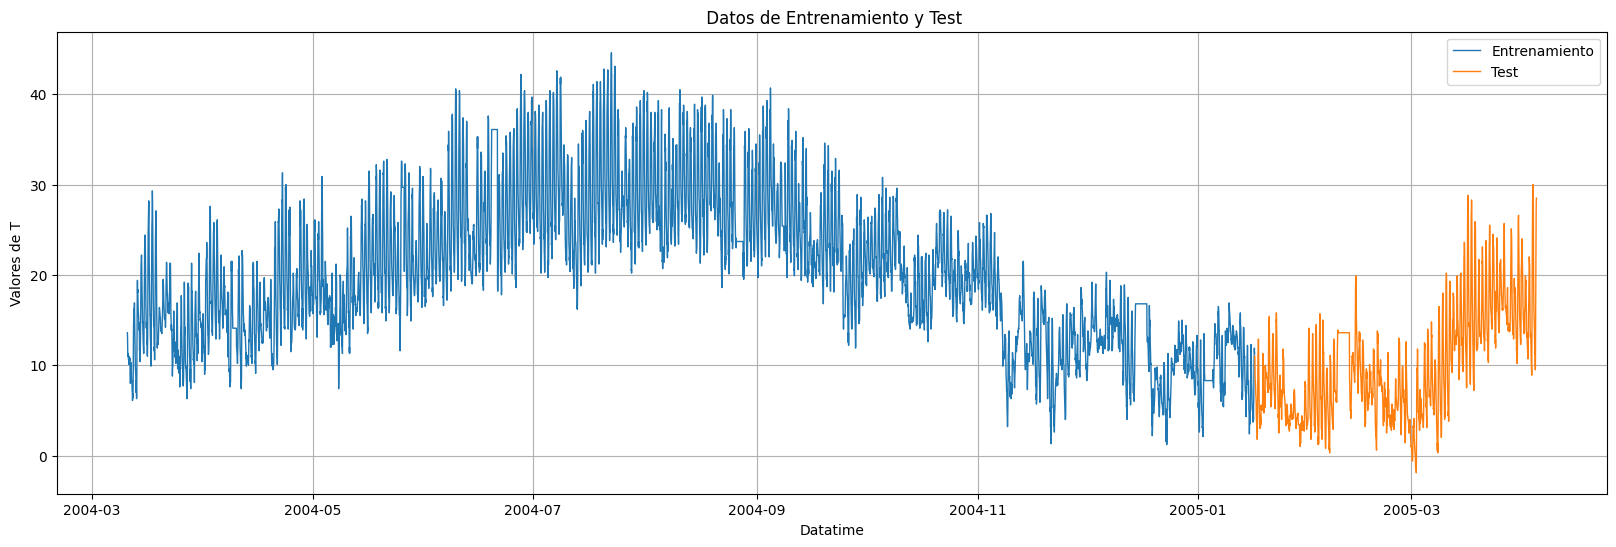

In [ ]:
#Grafico train y test
plt.figure(figsize=(20, 6))

plt.plot(df_train_T, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_test_T, label='Test', linestyle='-', linewidth=1)

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datatime')
plt.ylabel('Valores de T')

plt.legend()
plt.grid(True)
plt.show()

Analisis de Performance del MODELO 11


In [ ]:
import statsmodels.api as sm

In [ ]:
# Ajustamos el modelo11 SARIMA  con los datos de entrenamiento
modelo11_T_train = sm.tsa.SARIMAX(df_train_T, order=(1, 1, 0), seasonal_order=(2, 1, 1, 24))
resultados_modelo11 = modelo11_T_train.fit()

In [ ]:
# Realizar la predicción en el conjunto de prueba usando el comando FORECAST
predicciones_T = resultados_modelo11.get_forecast(steps=1871)
predicciones_T_mean = predicciones_T.predicted_mean
print(predicciones_T_mean)

2005-01-16 16:00:00    11.136522
2005-01-16 17:00:00    10.094828
2005-01-16 18:00:00     9.206192
2005-01-16 19:00:00     8.782947
2005-01-16 20:00:00     8.527175
                         ...    
2005-04-04 10:00:00    -3.862669
2005-04-04 11:00:00    -2.502342
2005-04-04 12:00:00    -1.671768
2005-04-04 13:00:00    -0.942296
2005-04-04 14:00:00    -0.661658
Freq: H, Name: predicted_mean, Length: 1871, dtype: float64


In [ ]:
# Intervalos de confianza
intervalos_confianza = predicciones_T.conf_int()
print(intervalos_confianza)

                        lower T     upper T
2005-01-16 16:00:00    9.179787   13.093257
2005-01-16 17:00:00    7.151186   13.038471
2005-01-16 18:00:00    5.513735   12.898649
2005-01-16 19:00:00    4.467852   13.098042
2005-01-16 20:00:00    3.668377   13.385972
...                         ...         ...
2005-04-04 10:00:00 -387.031059  379.305721
2005-04-04 11:00:00 -385.926078  380.921395
2005-04-04 12:00:00 -385.350680  382.007144
2005-04-04 13:00:00 -384.876215  382.991623
2005-04-04 14:00:00 -384.850414  383.527098

[1871 rows x 2 columns]


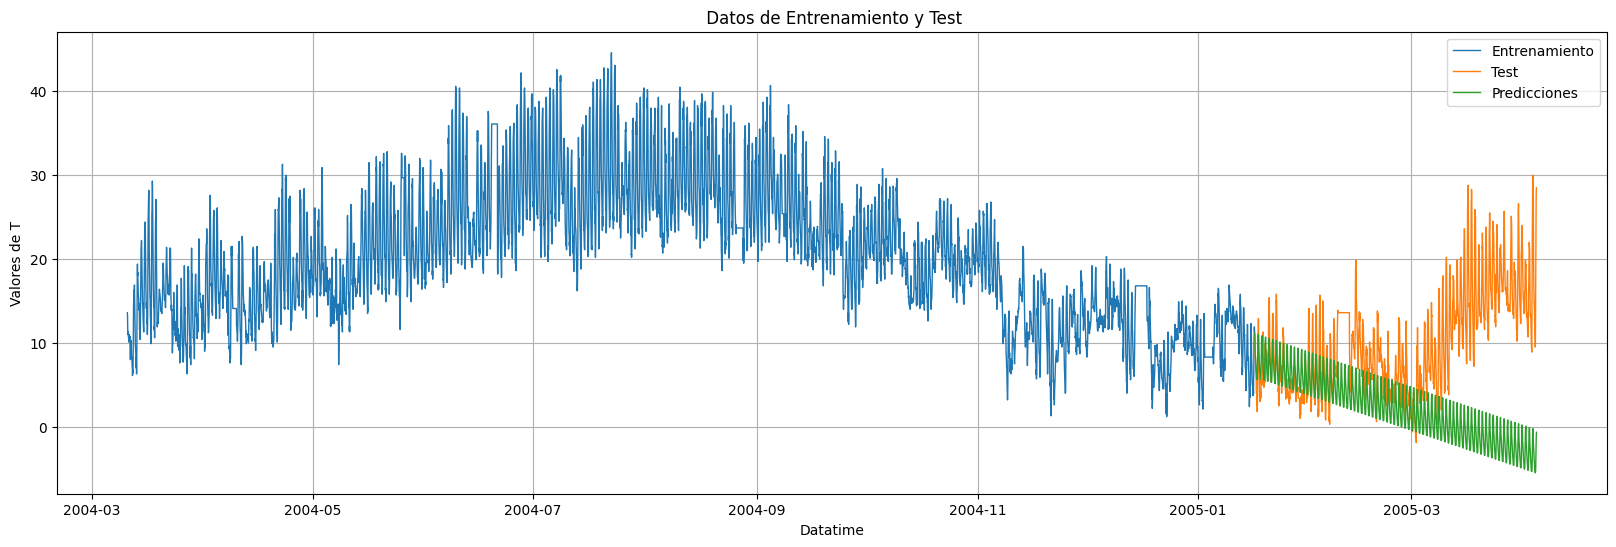

In [ ]:
# Graficamos los resultados
plt.figure(figsize=(20, 6))
plt.plot(df_train_T, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_test_T, label='Test', linestyle='-', linewidth=1)
plt.plot(df_test_T.index, predicciones_T_mean, label='Predicciones', linestyle='-', linewidth=1 )

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datatime')
plt.ylabel('Valores de T')
plt.grid(True)
plt.legend()
plt.show()


El pronostico da muy mal, para esta serie. Una explicación puede ser, porque no conoce la estacionalidad de la misma. Al no tener datos historicos de años anteriores, no entiende el comportamiento, de que la temperatura sube en los meses de primaver, alcanzando los valores mas altos durante los veranos. En este caso, esa información se pierde, y el pronostico que proyecat el modelo, sigue la curva de bajada de los datos con el que se entreno.

**Metricas de Performance:**

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# Error cuadrático medio (MSE)
mse_T = mean_squared_error(df_test_T, predicciones_T_mean )
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 11 variable T: {mse_T}")


Error cuadrático medio (MSE) en conjunto de prueba modelo 11 variable T: 123.3812404315122


In [ ]:
# Error absoluto medeio (MAE)
mae_T = mean_absolute_error(df_test_T, predicciones_T_mean)

print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 11 variable T: {mae_T}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 11 variable T: 8.372687907835072


In [ ]:
# Raiz cuadrada de MSE (RMSE)
rmse_T = np.sqrt(mse_T)

print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 11 variable T: {rmse_T}")

Raíz cuadrada del MSE en conjunto de prueba modelo 11 variable T: 11.107710854695139


# **PUNTO 7**
*Detallar una comparación con otros modelos estimados.*

Comparo con el Modelo 1 (segundo mejor modelo obtenido)

In [ ]:
# Ajustamos el modelo 1  con los datos de entrenamiento
modelo1_T_train = sm.tsa.SARIMAX(df_train_T, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
resultados_modelo1 = modelo1_T_train.fit()

In [ ]:
# Realizar la predicción en el conjunto de prueba usando el comando get_forecast
predicciones_T_2 = resultados_modelo1.get_forecast(steps=1871)
predicciones_T_2_mean = predicciones_T_2.predicted_mean

mse_T_2 = mean_squared_error(df_test_T, predicciones_T_2_mean)
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 1 variable T: {mse_T_2}")

Error cuadrático medio (MSE) en conjunto de prueba modelo 1 variable T: 124.05325831915742


In [ ]:
mae_T_2 = mean_absolute_error(df_test_T, predicciones_T_2_mean)
print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 1 variable T: {mae_T_2}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 1 variable T: 8.397308995188595


In [ ]:
rmse_T_2 = np.sqrt(mse_T_2)
print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 1 variable T: {rmse_T_2}")

Raíz cuadrada del MSE en conjunto de prueba modelo 1 variable T: 11.1379198380648


Comparo con el Modelo 8 (el peor valor de AIC obtenido)

In [ ]:
# Ajustamos el modelo 8  con los datos de entrenamiento
modelo8_T_train = sm.tsa.SARIMAX(df_train_T, order=(1, 1, 0), seasonal_order=(1, 1, 0, 24))
resultados_modelo8 = modelo8_T_train.fit()

In [ ]:
# Realizar la predicción en el conjunto de prueba usando el comando get_forecast
predicciones_T_3 = resultados_modelo8.get_forecast(steps=1871)
predicciones_T_3_mean = predicciones_T_3.predicted_mean

In [ ]:
mse_T_3 = mean_squared_error(df_test_T, predicciones_T_3_mean)
print(f"Error cuadrático medio (MSE) en conjunto de prueba modelo 8 variable T: {mse_T_3}")

Error cuadrático medio (MSE) en conjunto de prueba modelo 8 variable T: 1615.6570640221673


In [ ]:
mae_T_3 = mean_absolute_error(df_test_T, predicciones_T_3_mean)
print(f"Error Absoluto Medio (MAE) en conjunto de prueba modelo 8 variable T: {mae_T_3}")

Error Absoluto Medio (MAE) en conjunto de prueba modelo 8 variable T: 34.03862963339975


In [ ]:
rmse_T_3 = np.sqrt(mse_T_3)
print(f"Raíz cuadrada del MSE en conjunto de prueba modelo 8 variable T: {rmse_T_3}")

Raíz cuadrada del MSE en conjunto de prueba modelo 8 variable T: 40.19523683251745


[texto del vínculo](https://docs.google.com/spreadsheets/d/1a_1ifOEeA-F5Z702Jwmldl_1iOqBHnzh/edit?gid=260485930#gid=260485930)

Si bien, no podria determinar el modelo 11 como bueno, ya que quedo claro que no predice correctamente el comportamiento de mi serie, es el que tiene mejor performance. Se comparo con el modelo 1 y son bastantes similares; pero comparando con el modelo 8 (que es el que tenia mayor valor de AIC) se ve claramente como el performance del mismo, es mucho mas malo.

# **PUNTO 8**
*Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).*

Analisis de Residuos para el Modelo elegido

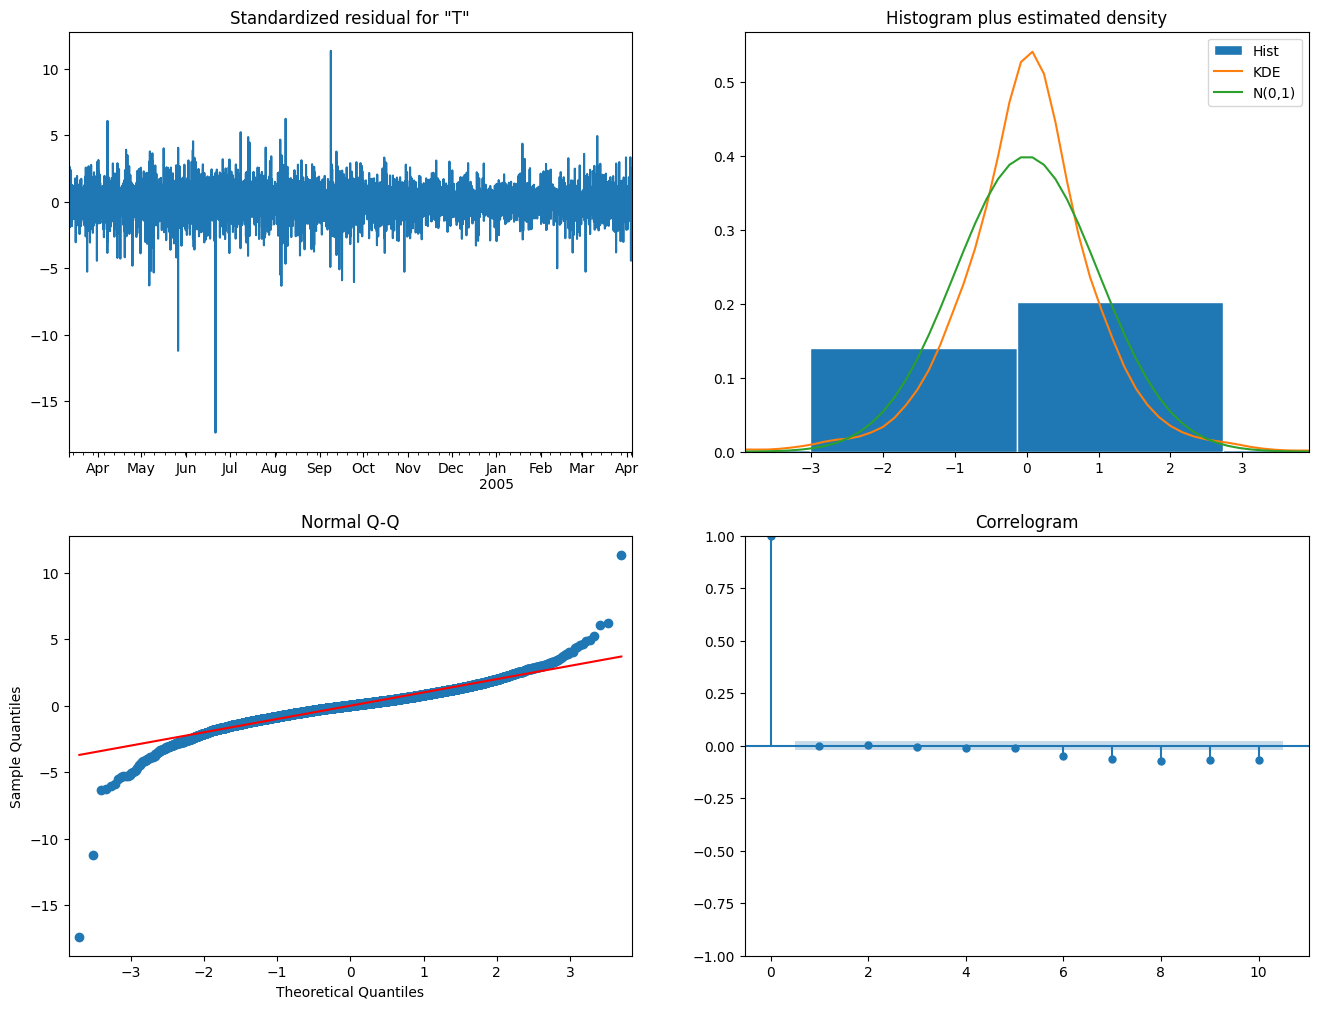

In [ ]:
modeloSARIMA_fit_T_11.plot_diagnostics(figsize=(16,12));

Test de Box Pierce Para confirmar que los residuos se comportan como ruido blanco (independientes y no autocorrelacionados) podemos usar el test de Box-Pierce y el de Ljung-Box.

In [ ]:
Incorrelacion_residuos_modelo11=sm.stats.acorr_ljungbox(modeloSARIMA_fit_T_11.resid, lags=48)
print(Incorrelacion_residuos_modelo11)

       lb_stat     lb_pvalue
1     0.000865  9.765335e-01
2     0.043322  9.785718e-01
3     0.264647  9.665342e-01
4     0.898055  9.248397e-01
5     1.782127  8.783951e-01
6    24.525622  4.178612e-04
7    60.316212  1.305266e-10
8   106.863509  1.677778e-19
9   150.366954  7.403396e-28
10  192.359655  6.309639e-36
11  209.581326  7.611320e-39
12  224.439410  2.846919e-41
13  232.840068  2.313034e-42
14  262.815576  6.380439e-48
15  271.146064  5.364694e-49
16  274.089541  5.759860e-49
17  274.107392  2.410309e-48
18  275.114061  6.136218e-48
19  275.132601  2.420669e-47
20  277.577947  2.985625e-47
21  279.544994  4.519344e-47
22  291.854277  5.455634e-49
23  318.729521  7.374876e-54
24  319.277910  2.156988e-53
25  350.033348  4.783512e-59
26  355.140240  1.677176e-59
27  357.704120  1.904802e-59
28  358.142471  5.727109e-59
29  360.466572  7.072745e-59
30  360.913665  2.052423e-58
31  369.098433  1.661145e-59
32  372.782824  1.064989e-59
33  383.153940  3.138769e-61
34  384.345917

Text(0, 0.5, 'P-valores ')

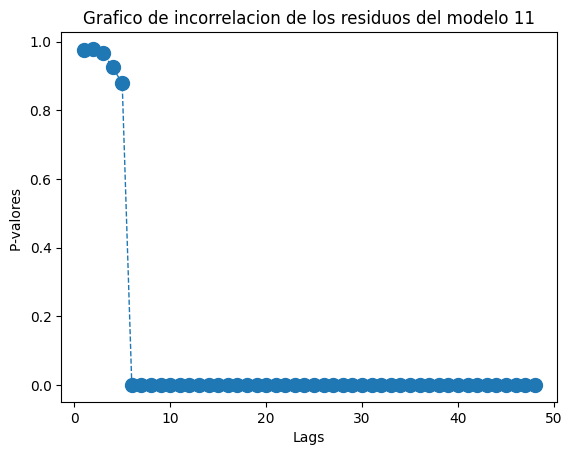

In [ ]:
plt.plot(Incorrelacion_residuos_modelo11.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo 11")
plt.xlabel("Lags")
plt.ylabel("P-valores ")

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

In [ ]:
# Test Box-Pierce
lags = 24
acf_values = sm.tsa.acf(modeloSARIMA_fit_T_11.resid, nlags=lags, fft=False)

#Calculamos el estadistico de prueba Q de Box-Pierce
n = len(modeloSARIMA_fit_T_11.resid)
Q = n * np.sum(np.square(acf_values[1:lags+1]))
p_value = 1 - chi2.cdf(Q, df=lags)

print(f'Estadística de prueba (Q): {Q:.4f}')
print(f'Valor p: {p_value:.4f}')
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.")
else:
    print("No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.")

Estadística de prueba (Q): 318.8188
Valor p: 0.0000
Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.


Conclusión: analizando los residuos del Modelo 11 (elegido como el mejor), comprobamos que NO es un buen modelo. Los residuos no cumplen con el principio de normalidad, y no estan autocorrelacionados.

# **PUNTO 9**
 *Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.*

In [ ]:
#Tomamos una ventana de 24 horas
Pronostico_T = modeloSARIMA_fit_T_11.get_forecast(steps=24)
Intervalo_confianza_pronostico = Pronostico_T.conf_int()
Pronostico_T_mean = Pronostico_T.predicted_mean

In [ ]:
# Crear el rango de fechas para las predicciones
ultimo_dato = df_test_T.index[-1]
datos_prediccion = pd.date_range(start=ultimo_dato, periods=24, freq='H')
print(datos_prediccion)

DatetimeIndex(['2005-04-04 14:00:00', '2005-04-04 15:00:00',
               '2005-04-04 16:00:00', '2005-04-04 17:00:00',
               '2005-04-04 18:00:00', '2005-04-04 19:00:00',
               '2005-04-04 20:00:00', '2005-04-04 21:00:00',
               '2005-04-04 22:00:00', '2005-04-04 23:00:00',
               '2005-04-05 00:00:00', '2005-04-05 01:00:00',
               '2005-04-05 02:00:00', '2005-04-05 03:00:00',
               '2005-04-05 04:00:00', '2005-04-05 05:00:00',
               '2005-04-05 06:00:00', '2005-04-05 07:00:00',
               '2005-04-05 08:00:00', '2005-04-05 09:00:00',
               '2005-04-05 10:00:00', '2005-04-05 11:00:00',
               '2005-04-05 12:00:00', '2005-04-05 13:00:00'],
              dtype='datetime64[ns]', freq='H')


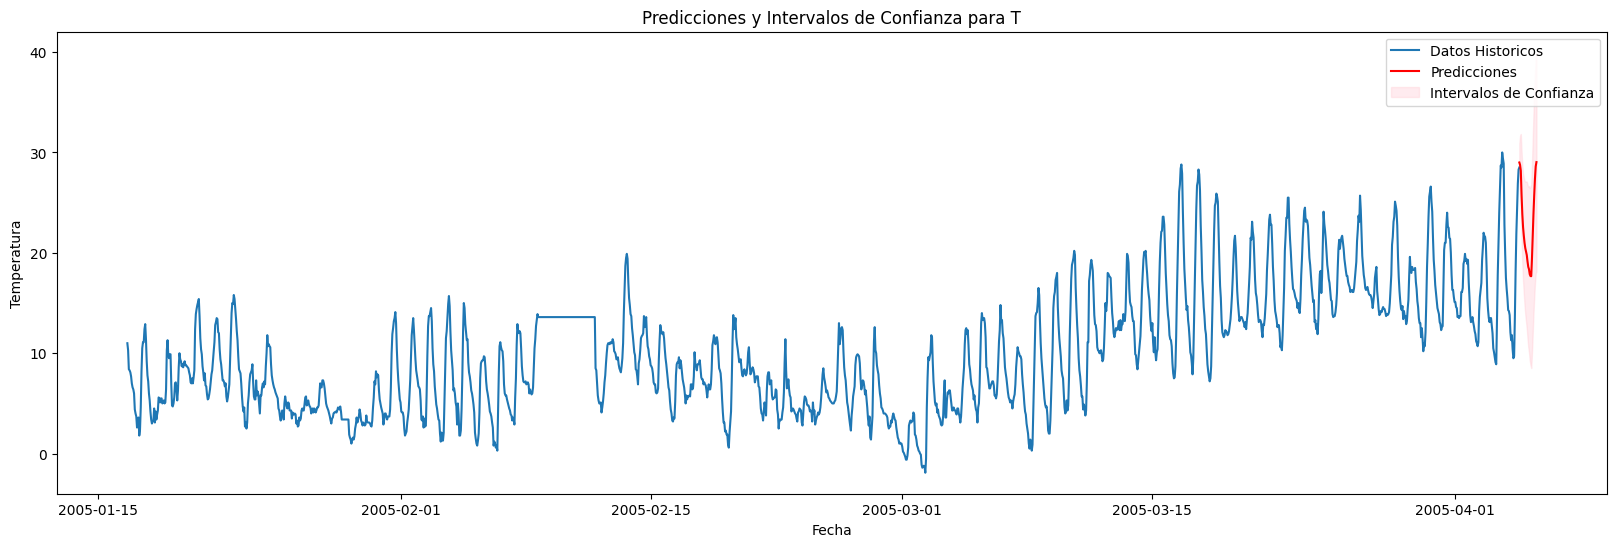

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_test_T.index, df_test_T, label='Datos Historicos')
plt.plot(datos_prediccion, Pronostico_T_mean, label='Predicciones', color='red')
plt.fill_between(datos_prediccion,
                 Intervalo_confianza_pronostico.iloc[:, 0],
                 Intervalo_confianza_pronostico.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de Confianza')

# Configuración adicional de la gráfica
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicciones y Intervalos de Confianza para T')
plt.show()

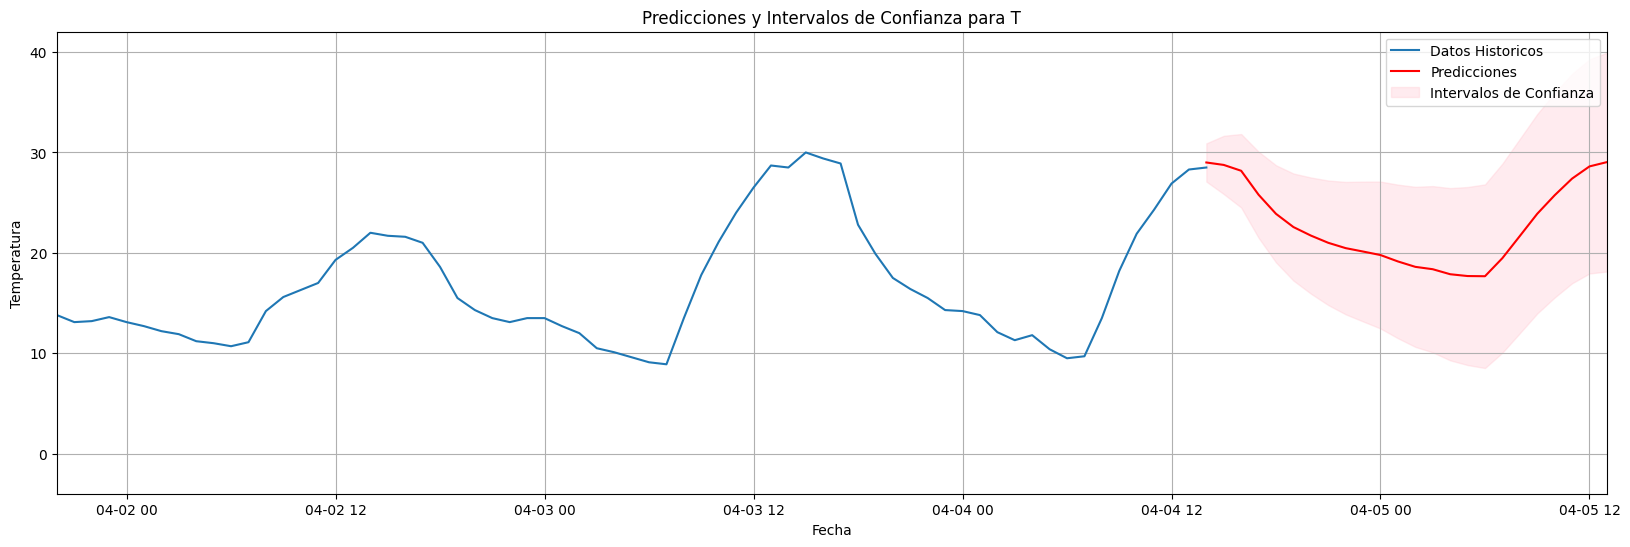

In [ ]:

plt.figure(figsize=(20, 6))
start_date = pd.Timestamp('2005-04-01 20:00:00')
end_date = pd.Timestamp('2005-04-05 13:00:00')
plt.plot(df_test_T.index, df_test_T, label='Datos Historicos')
plt.plot(datos_prediccion, Pronostico_T_mean, label='Predicciones', color='red')
plt.fill_between(datos_prediccion,
                 Intervalo_confianza_pronostico.iloc[:, 0],
                 Intervalo_confianza_pronostico.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalos de Confianza')

plt.xlim(start_date, end_date)
plt.grid(True)
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicciones y Intervalos de Confianza para T')
plt.show()